In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
DATA_PATH = "../data/"
train = pd.read_csv(DATA_PATH + 'train.csv')

In [3]:
print("="*80)
print("전처리 전략: 노이즈 패턴 영향도 분석")
print("="*80)

# ========================================
# 1. 노이즈 패턴 정의 및 탐지
# ========================================
print("\n### 1단계: 노이즈 패턴 탐지 ###\n")

def detect_noise_patterns(text):
    """모든 노이즈 패턴 탐지"""
    if pd.isna(text):
        return {}
    
    text_str = str(text)
    patterns = {
        'escaped_newline': bool(re.search(r'\\\\n', text_str)),  # \\n
        'html_br': bool(re.search(r'<br\s*/?>', text_str, re.IGNORECASE)),  # <br>
        'multiple_spaces': bool(re.search(r'\s{3,}', text_str)),  # 3개 이상 공백
        'special_chars': bool(re.search(r'[^\w\s가-힣#:.\n]{3,}', text_str)),  # 특수문자 연속
        'inconsistent_speaker': bool(re.search(r'#Person\d+#(?!\s*:)', text_str)),  # 화자 후 : 없음
        'mixed_newlines': '\\n' in text_str and '\n' in text_str,  # \\n과 \n 혼재
    }
    return patterns

# 각 샘플의 노이즈 패턴 탐지
train['noise_patterns'] = train['dialogue'].apply(detect_noise_patterns)

# 노이즈 유형별로 boolean 컬럼 생성
for pattern_name in ['escaped_newline', 'html_br', 'multiple_spaces', 
                     'special_chars', 'inconsistent_speaker', 'mixed_newlines']:
    train[f'has_{pattern_name}'] = train['noise_patterns'].apply(
        lambda x: x.get(pattern_name, False)
    )

# 전체 노이즈 개수
train['total_noise_count'] = train[[f'has_{p}' for p in 
    ['escaped_newline', 'html_br', 'multiple_spaces', 'special_chars', 
     'inconsistent_speaker', 'mixed_newlines']]].sum(axis=1)


전처리 전략: 노이즈 패턴 영향도 분석

### 1단계: 노이즈 패턴 탐지 ###



In [4]:
# 노이즈 패턴별 출현 빈도
print("노이즈 패턴별 출현 빈도:")
for pattern_name in ['escaped_newline', 'html_br', 'multiple_spaces', 
                     'special_chars', 'inconsistent_speaker', 'mixed_newlines']:
    count = train[f'has_{pattern_name}'].sum()
    pct = count / len(train) * 100
    print(f"  {pattern_name:25s}: {count:5,}개 ({pct:5.2f}%)")

print(f"\n노이즈 없는 데이터: {(train['total_noise_count'] == 0).sum():,}개 "
      f"({(train['total_noise_count'] == 0).sum()/len(train)*100:.2f}%)")
print(f"노이즈 있는 데이터: {(train['total_noise_count'] > 0).sum():,}개 "
      f"({(train['total_noise_count'] > 0).sum()/len(train)*100:.2f}%)")

노이즈 패턴별 출현 빈도:
  escaped_newline          :     0개 ( 0.00%)
  html_br                  :     1개 ( 0.01%)
  multiple_spaces          :    24개 ( 0.19%)
  special_chars            :    23개 ( 0.18%)
  inconsistent_speaker     :    67개 ( 0.54%)
  mixed_newlines           :     0개 ( 0.00%)

노이즈 없는 데이터: 12,342개 (99.08%)
노이즈 있는 데이터: 115개 (0.92%)


In [5]:
# ========================================
# 2. 노이즈 패턴별 영향도 분석
# ========================================
print("\n\n### 2단계: 노이즈 패턴별 영향도 분석 ###\n")

# 대화 길이 계산
train['dialogue_length'] = train['dialogue'].apply(lambda x: len(str(x)))
train['summary_length'] = train['summary'].apply(lambda x: len(str(x)))

print("2-1. 노이즈 패턴별 평균 대화 길이 비교\n")
print(f"{'패턴':<25} {'노이즈 있음':>12} {'노이즈 없음':>12} {'차이':>10}")
print("-" * 65)

for pattern_name in ['escaped_newline', 'html_br', 'multiple_spaces', 
                     'special_chars', 'inconsistent_speaker', 'mixed_newlines']:
    col = f'has_{pattern_name}'
    with_noise = train[train[col]]['dialogue_length'].mean()
    without_noise = train[~train[col]]['dialogue_length'].mean()
    diff = with_noise - without_noise
    
    print(f"{pattern_name:<25} {with_noise:>12.1f} {without_noise:>12.1f} {diff:>+10.1f}")

print("\n2-2. 노이즈 개수별 통계\n")
noise_stats = train.groupby('total_noise_count').agg({
    'dialogue_length': ['count', 'mean'],
    'summary_length': 'mean'
}).round(1)
print(noise_stats)



### 2단계: 노이즈 패턴별 영향도 분석 ###

2-1. 노이즈 패턴별 평균 대화 길이 비교

패턴                              노이즈 있음       노이즈 없음         차이
-----------------------------------------------------------------
escaped_newline                    nan        406.1       +nan
html_br                          390.0        406.1      -16.1
multiple_spaces                  522.3        405.9     +116.4
special_chars                    865.0        405.2     +459.7
inconsistent_speaker             404.5        406.1       -1.6
mixed_newlines                     nan        406.1       +nan

2-2. 노이즈 개수별 통계

                  dialogue_length        summary_length
                            count   mean           mean
total_noise_count                                      
0                           12342  405.0           85.7
1                             115  521.1           97.2


In [6]:
# ========================================
# 3. 전처리 함수 정의
# ========================================
print("\n\n### 3단계: 전처리 함수 정의 ###\n")

def preprocess_v1_baseline(text):
    """Baseline 전처리 (최소한의 처리)"""
    if pd.isna(text):
        return ""
    return str(text)

def preprocess_v2_basic(text):
    """기본 전처리"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # HTML 태그 제거
    text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
    
    # 이스케이프된 개행 문자 정규화
    text = text.replace('\\n', '\n')
    
    # 다중 공백 정리
    text = re.sub(r' {2,}', ' ', text)
    
    return text.strip()

def preprocess_v3_advanced(text):
    """고급 전처리"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # HTML 태그 처리
    text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
    text = re.sub(r'<[^>]+>', '', text)
    
    # 개행 문자 정규화
    text = text.replace('\\n', '\n')
    
    # 화자 정보 정규화 (# 뒤에 : 추가)
    text = re.sub(r'#Person(\d+)#(?!\s*:)', r'#Person\1#:', text)
    
    # 다중 공백 정리
    text = re.sub(r' {2,}', ' ', text)
    
    # 연속된 개행 정리 (3개 이상 -> 2개)
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 각 라인 앞뒤 공백 제거
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    text = '\n'.join(lines)
    
    return text.strip()

def preprocess_v4_aggressive(text):
    """적극적 전처리"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # HTML 태그 처리
    text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
    text = re.sub(r'<[^>]+>', '', text)
    
    # 개행 문자 정규화
    text = text.replace('\\n', '\n')
    
    # 화자 정보 정규화
    text = re.sub(r'#Person(\d+)#(?!\s*:)', r'#Person\1#:', text)
    
    # 불필요한 특수문자 제거 (화자 태그, 콜론, 마침표, 물음표, 느낌표는 유지)
    text = re.sub(r'[^\w\s가-힣#:.\n!?]', '', text)
    
    # 공백 정리
    text = re.sub(r' {2,}', ' ', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 각 라인 정리
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    text = '\n'.join(lines)
    
    # 빈 대화 제거
    lines = [line for line in lines if len(line) > 3]
    text = '\n'.join(lines)
    
    return text.strip()

# 전처리 버전별 적용
preprocessing_versions = {
    'v1_baseline': preprocess_v1_baseline,
    'v2_basic': preprocess_v2_basic,
    'v3_advanced': preprocess_v3_advanced,
    'v4_aggressive': preprocess_v4_aggressive
}

# 샘플 데이터로 테스트 (전체 적용은 시간이 오래 걸림)
sample_size = min(1000, len(train))
sample_df = train.sample(sample_size, random_state=42).copy()

for version_name, preprocess_func in preprocessing_versions.items():
    sample_df[f'dialogue_{version_name}'] = sample_df['dialogue'].apply(preprocess_func)
    sample_df[f'length_{version_name}'] = sample_df[f'dialogue_{version_name}'].apply(len)




### 3단계: 전처리 함수 정의 ###



In [7]:
# ========================================
# 3. 전처리 함수 정의
# ========================================
print("\n\n### 3단계: 전처리 함수 정의 ###\n")

def preprocess_v1_baseline(text):
    """Baseline 전처리 (최소한의 처리)"""
    if pd.isna(text):
        return ""
    return str(text)

def preprocess_v2_basic(text):
    """기본 전처리"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # HTML 태그 제거
    text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
    
    # 이스케이프된 개행 문자 정규화
    text = text.replace('\\n', '\n')
    
    # 다중 공백 정리
    text = re.sub(r' {2,}', ' ', text)
    
    return text.strip()

def preprocess_v3_advanced(text):
    """고급 전처리"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # HTML 태그 처리
    text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
    text = re.sub(r'<[^>]+>', '', text)
    
    # 개행 문자 정규화
    text = text.replace('\\n', '\n')
    
    # 화자 정보 정규화 (# 뒤에 : 추가)
    text = re.sub(r'#Person(\d+)#(?!\s*:)', r'#Person\1#:', text)
    
    # 다중 공백 정리
    text = re.sub(r' {2,}', ' ', text)
    
    # 연속된 개행 정리 (3개 이상 -> 2개)
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 각 라인 앞뒤 공백 제거
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    text = '\n'.join(lines)
    
    return text.strip()

def preprocess_v4_aggressive(text):
    """적극적 전처리"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # HTML 태그 처리
    text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
    text = re.sub(r'<[^>]+>', '', text)
    
    # 개행 문자 정규화
    text = text.replace('\\n', '\n')
    
    # 화자 정보 정규화
    text = re.sub(r'#Person(\d+)#(?!\s*:)', r'#Person\1#:', text)
    
    # 불필요한 특수문자 제거 (화자 태그, 콜론, 마침표, 물음표, 느낌표는 유지)
    text = re.sub(r'[^\w\s가-힣#:.\n!?]', '', text)
    
    # 공백 정리
    text = re.sub(r' {2,}', ' ', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 각 라인 정리
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    text = '\n'.join(lines)
    
    # 빈 대화 제거
    lines = [line for line in lines if len(line) > 3]
    text = '\n'.join(lines)
    
    return text.strip()



### 3단계: 전처리 함수 정의 ###



In [8]:
# ========================================
# 4. 전처리 전후 비교
# ========================================
print("\n### 4단계: 전처리 버전별 효과 비교 (샘플 1000개) ###\n")

print("4-1. 평균 길이 변화\n")
print(f"{'버전':<15} {'평균 길이':>12} {'원본 대비':>12} {'길이 변화율':>12}")
print("-" * 55)

original_length = sample_df['dialogue_length'].mean()
print(f"{'원본':<15} {original_length:>12.1f} {0:>12.1f} {0:>11.1f}%")

for version_name in ['v1_baseline', 'v2_basic', 'v3_advanced', 'v4_aggressive']:
    avg_length = sample_df[f'length_{version_name}'].mean()
    diff = avg_length - original_length
    pct_change = (diff / original_length) * 100
    print(f"{version_name:<15} {avg_length:>12.1f} {diff:>+12.1f} {pct_change:>+11.1f}%")



### 4단계: 전처리 버전별 효과 비교 (샘플 1000개) ###

4-1. 평균 길이 변화

버전                     평균 길이        원본 대비       길이 변화율
-------------------------------------------------------
원본                     413.1          0.0         0.0%
v1_baseline            413.1         +0.0        +0.0%
v2_basic               413.0         -0.1        -0.0%
v3_advanced            411.2         -1.9        -0.5%
v4_aggressive          406.0         -7.1        -1.7%


In [9]:
print("\n4-2. 노이즈 제거 효과\n")

# 각 버전별로 노이즈 패턴 재탐지
for version_name in ['v1_baseline', 'v2_basic', 'v3_advanced', 'v4_aggressive']:
    sample_df[f'noise_{version_name}'] = sample_df[f'dialogue_{version_name}'].apply(
        lambda x: sum(detect_noise_patterns(x).values())
    )

print(f"{'버전':<15} {'평균 노이즈 수':>15} {'노이즈 감소율':>15}")
print("-" * 50)

original_noise = sample_df['total_noise_count'].mean()
print(f"{'원본':<15} {original_noise:>15.2f} {0:>14.1f}%")

for version_name in ['v1_baseline', 'v2_basic', 'v3_advanced', 'v4_aggressive']:
    avg_noise = sample_df[f'noise_{version_name}'].mean()
    reduction = ((original_noise - avg_noise) / original_noise) * 100 if original_noise > 0 else 0
    print(f"{version_name:<15} {avg_noise:>15.2f} {reduction:>14.1f}%")


4-2. 노이즈 제거 효과

버전                     평균 노이즈 수         노이즈 감소율
--------------------------------------------------
원본                         0.01            0.0%
v1_baseline                0.01            0.0%
v2_basic                   0.01           38.5%
v3_advanced                0.00           69.2%
v4_aggressive              0.00           76.9%


In [11]:
# ========================================
# 5. 전처리 전후 예시
# ========================================
print("\n\n### 5단계: 전처리 전후 실제 예시 ###\n")

# 노이즈가 있는 샘플 찾기 (없으면 일반 샘플 사용)
noisy_samples = train[train['total_noise_count'] >= 1]
if len(noisy_samples) == 0:
    print("노이즈가 있는 샘플이 없습니다. 일반 샘플 3개를 사용합니다.\n")
    sample_indices = [0, 100, 500]
else:
    print(f"노이즈가 있는 샘플 {len(noisy_samples)}개 발견. 상위 3개를 사용합니다.\n")
    # 노이즈가 많은 순서대로 정렬
    noisy_samples = noisy_samples.sort_values('total_noise_count', ascending=False)
    sample_indices = noisy_samples.index[:min(3, len(noisy_samples))]

for idx, sample_idx in enumerate(sample_indices, 1):
    sample = train.loc[sample_idx]
    
    print("=" * 80)
    print(f"예시 {idx}: {'노이즈 ' + str(int(sample['total_noise_count'])) + '개 포함' if sample['total_noise_count'] > 0 else '노이즈 없음'}")
    print("=" * 80)
    
    # 노이즈 패턴 확인
    if sample['total_noise_count'] > 0:
        print("\n감지된 노이즈 패턴:")
        for pattern in ['escaped_newline', 'html_br', 'multiple_spaces', 
                       'special_chars', 'inconsistent_speaker', 'mixed_newlines']:
            if sample[f'has_{pattern}']:
                print(f"  - {pattern}")
    
    print(f"\n원본 길이: {len(sample['dialogue'])}자")
    print("\n[원본]")
    print(sample['dialogue'][:300] + ("..." if len(sample['dialogue']) > 300 else ""))

    for version_name, preprocess_func in preprocessing_versions.items():
        processed = preprocess_func(sample['dialogue'])
        print(f"\n[{version_name}] (길이: {len(processed)}자)")
        print(processed[:300] + ("..." if len(processed) > 300 else ""))
    
    print("\n")



### 5단계: 전처리 전후 실제 예시 ###

노이즈가 있는 샘플 115개 발견. 상위 3개를 사용합니다.

예시 1: 노이즈 1개 포함

감지된 노이즈 패턴:
  - inconsistent_speaker

원본 길이: 231자

[원본]
#Person1#: 우리랑 같이 일할 거야?
#Person2#: 내가 녹색 메모장을 다시 사용할 수 있나? 칭찬의 메모를 쓰려고.
#Person1#: 그건 협상해 봐야지. 가능성은 있어.
#Person2#: 날 그리워하는 건 아니지?
#Person1#: 너무 나가진 마, #Person2#.
#Person2#: 좋아, 할게. 언제 시작하면 돼?
#Person1#: 가능한 빨리 여기로 와. 우리는 기다리고 있을게.

[v1_baseline] (길이: 231자)
#Person1#: 우리랑 같이 일할 거야?
#Person2#: 내가 녹색 메모장을 다시 사용할 수 있나? 칭찬의 메모를 쓰려고.
#Person1#: 그건 협상해 봐야지. 가능성은 있어.
#Person2#: 날 그리워하는 건 아니지?
#Person1#: 너무 나가진 마, #Person2#.
#Person2#: 좋아, 할게. 언제 시작하면 돼?
#Person1#: 가능한 빨리 여기로 와. 우리는 기다리고 있을게.

[v2_basic] (길이: 231자)
#Person1#: 우리랑 같이 일할 거야?
#Person2#: 내가 녹색 메모장을 다시 사용할 수 있나? 칭찬의 메모를 쓰려고.
#Person1#: 그건 협상해 봐야지. 가능성은 있어.
#Person2#: 날 그리워하는 건 아니지?
#Person1#: 너무 나가진 마, #Person2#.
#Person2#: 좋아, 할게. 언제 시작하면 돼?
#Person1#: 가능한 빨리 여기로 와. 우리는 기다리고 있을게.

[v3_advanced] (길이: 232자)
#Person1#: 우리랑 같이 일할 거야?
#Person2#: 내가 녹색 메모장을 다시 사용할 수 있나? 칭찬의 메모를 쓰려고.
#Person1#: 그건 협상해 봐

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/tmp/ipykernel_210963/569255413.py:47: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_210963/569255413.py:47: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_210963/569255413.py:47: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Ma



### 6단계: 시각화 생성 중... ###



findfont: Font family 'Malgun Gothic' not found.
/tmp/ipykernel_210963/569255413.py:48: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.savefig('preprocessing_analysis.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_210963/569255413.py:48: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.savefig('preprocessing_analysis.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_210963/569255413.py:48: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.savefig('preprocessing_analysis.png', dpi=300, bbox_inches='tight')
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/tmp/ipykerne

시각화 저장 완료: preprocessing_analysis.png


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

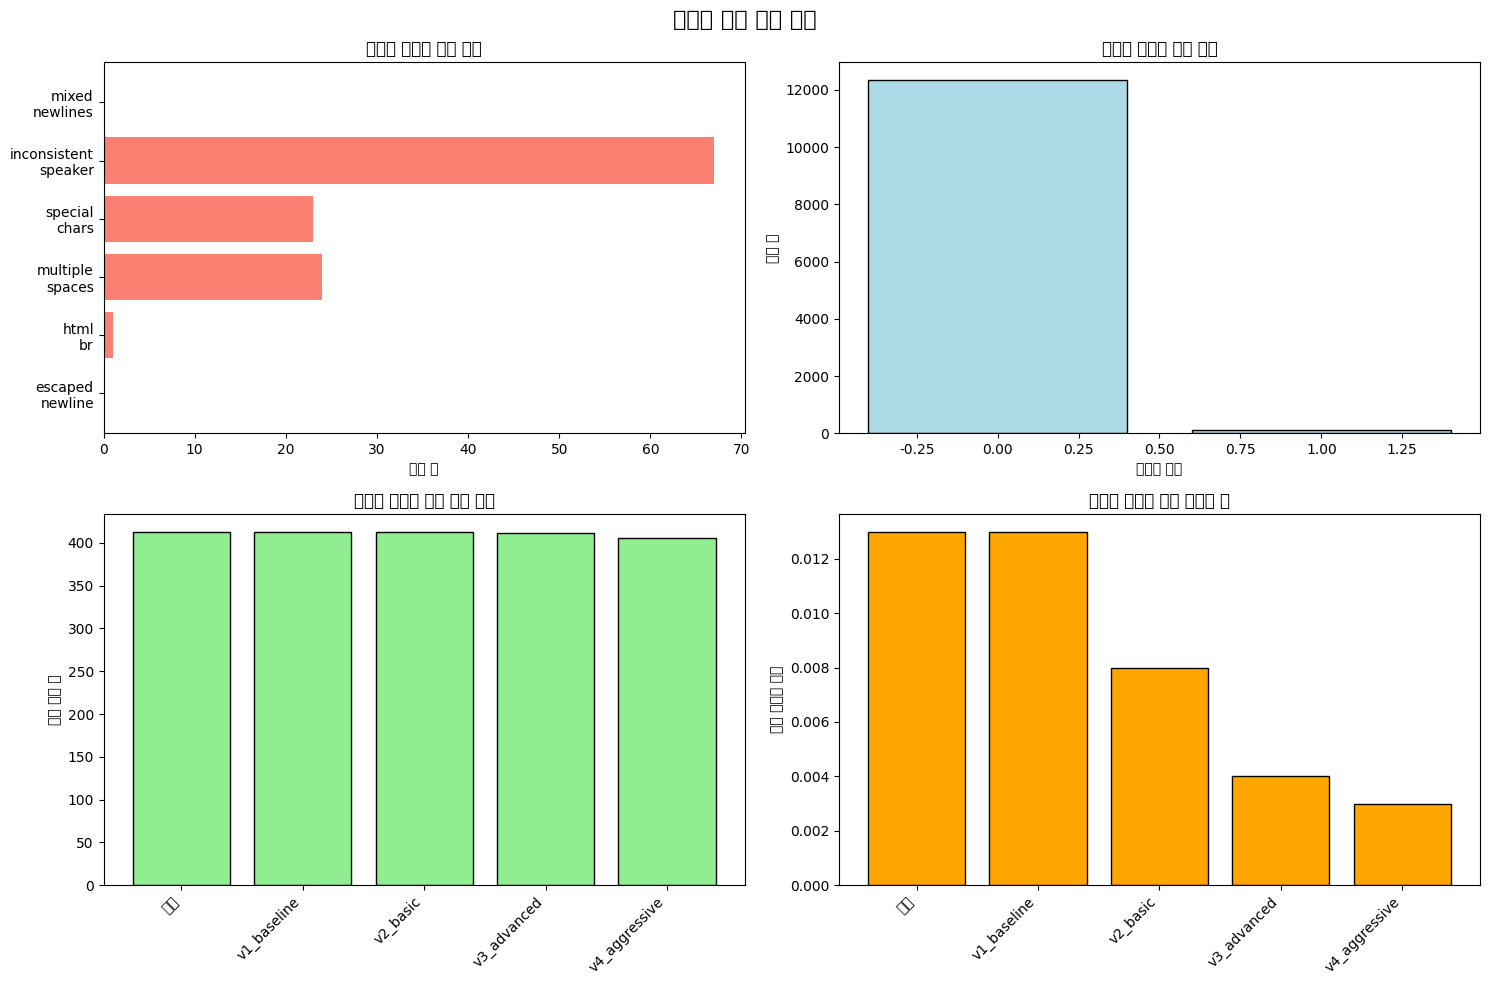

In [12]:
# ========================================
# 6. 시각화
# ========================================
print("\n\n### 6단계: 시각화 생성 중... ###\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('전처리 전략 비교 분석', fontsize=16, fontweight='bold')

# 1. 노이즈 패턴별 빈도
noise_counts = {}
for pattern_name in ['escaped_newline', 'html_br', 'multiple_spaces', 
                     'special_chars', 'inconsistent_speaker', 'mixed_newlines']:
    noise_counts[pattern_name.replace('_', '\n')] = train[f'has_{pattern_name}'].sum()

axes[0, 0].barh(list(noise_counts.keys()), list(noise_counts.values()), color='salmon')
axes[0, 0].set_title('노이즈 패턴별 출현 빈도')
axes[0, 0].set_xlabel('샘플 수')

# 2. 노이즈 개수별 분포
noise_dist = train['total_noise_count'].value_counts().sort_index()
axes[0, 1].bar(noise_dist.index, noise_dist.values, color='lightblue', edgecolor='black')
axes[0, 1].set_title('샘플당 노이즈 개수 분포')
axes[0, 1].set_xlabel('노이즈 개수')
axes[0, 1].set_ylabel('샘플 수')

# 3. 전처리 버전별 평균 길이
versions = ['원본', 'v1_baseline', 'v2_basic', 'v3_advanced', 'v4_aggressive']
lengths = [sample_df['dialogue_length'].mean()] + \
          [sample_df[f'length_{v}'].mean() for v in versions[1:]]

axes[1, 0].bar(range(len(versions)), lengths, color='lightgreen', edgecolor='black')
axes[1, 0].set_xticks(range(len(versions)))
axes[1, 0].set_xticklabels(versions, rotation=45, ha='right')
axes[1, 0].set_title('전처리 버전별 평균 대화 길이')
axes[1, 0].set_ylabel('평균 문자 수')

# 4. 노이즈 제거 효과
noise_reductions = [sample_df['total_noise_count'].mean()] + \
                   [sample_df[f'noise_{v}'].mean() for v in versions[1:]]

axes[1, 1].bar(range(len(versions)), noise_reductions, color='orange', edgecolor='black')
axes[1, 1].set_xticks(range(len(versions)))
axes[1, 1].set_xticklabels(versions, rotation=45, ha='right')
axes[1, 1].set_title('전처리 버전별 평균 노이즈 수')
axes[1, 1].set_ylabel('평균 노이즈 개수')

plt.tight_layout()
plt.savefig('preprocessing_analysis.png', dpi=300, bbox_inches='tight')
print("시각화 저장 완료: preprocessing_analysis.png")

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/tmp/ipykernel_210963/2909857509.py:135: UserWarning: Glyph 44032 (\N



### Step 6: Generating visualizations... ###



findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/tmp/ipykernel_210963/2909857509.py:135: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_210963/2909857509.py:135: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_210963/2909857509.py:135: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_210963/2909857509.py:135: UserWarning: Glyph 44053 (\N

Saved figure: preprocessing_analysis_en_ko.png (영문 라벨 + 한글 주석)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45458 (\N{HANGUL SYLLABLE NOP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pyla

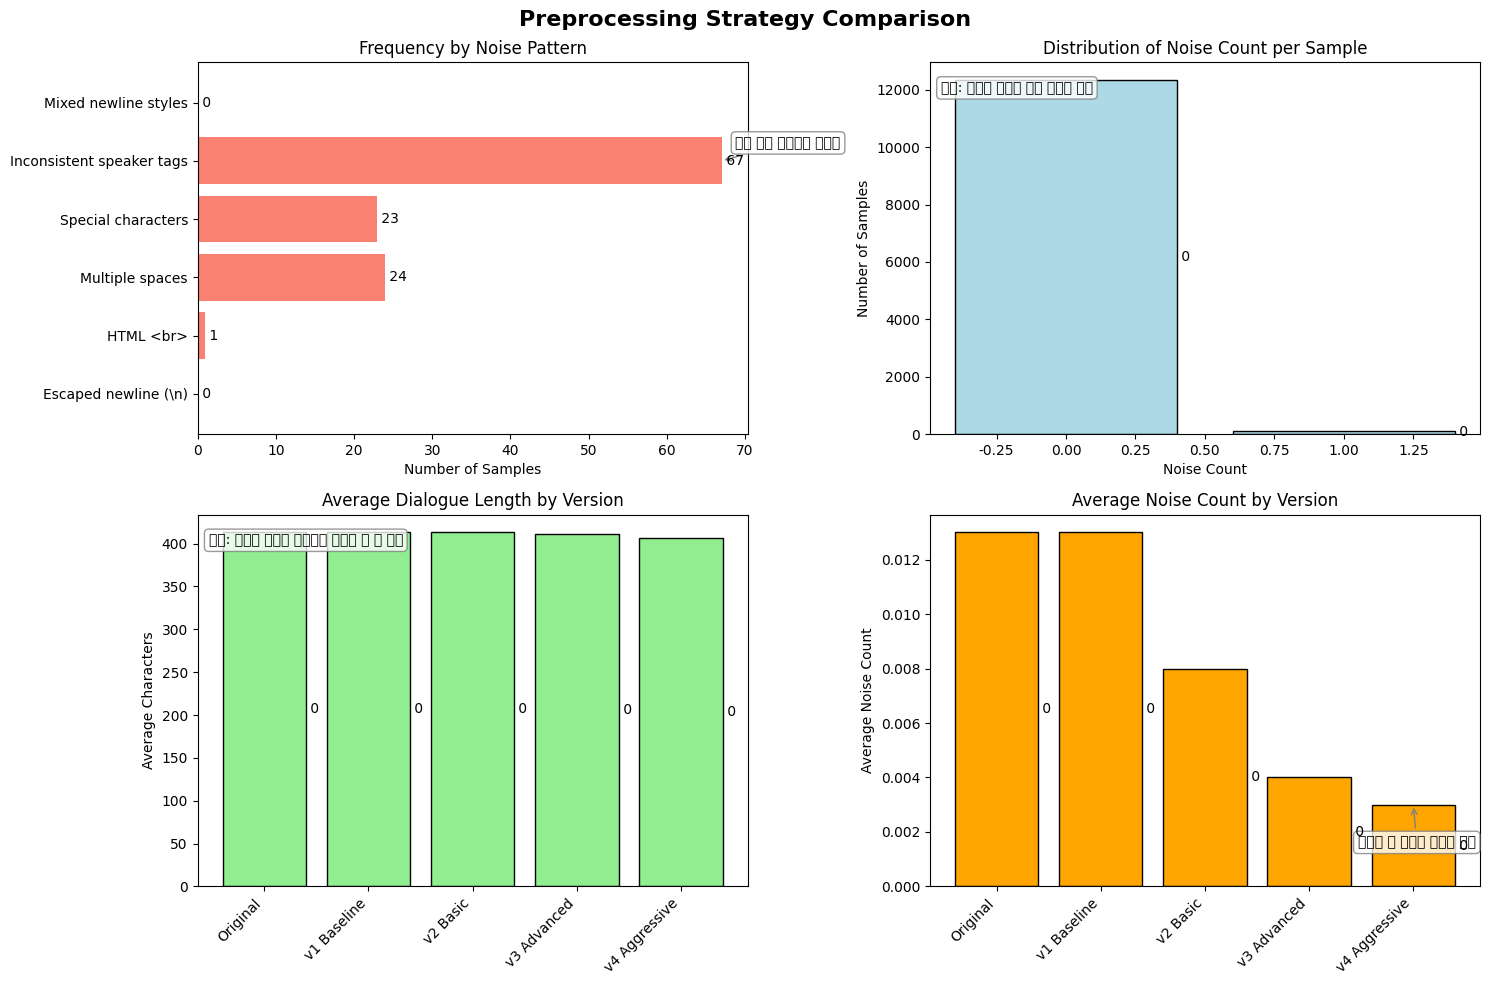

In [16]:
# ========================================
# 6. Visualization (English labels + Korean annotations)
# ========================================
print("\n\n### Step 6: Generating visualizations... ###\n")

import matplotlib.pyplot as plt
import matplotlib as mpl

# ---- (Optional) Korean font setup for annotations ----
# Try common fonts; if not found, just continue.
for fm in ["NanumGothic", "Malgun Gothic", "AppleGothic"]:
    try:
        mpl.font_manager.fontManager.addfont(f"/usr/share/fonts/truetype/{fm}.ttf")
    except Exception:
        pass

# Apply a font family that often exists on Linux images (Nanum) or fallback
for fam in ["NanumGothic", "Malgun Gothic", "AppleGothic"]:
    if fam in [f.name for f in mpl.font_manager.fontManager.ttflist]:
        plt.rcParams["font.family"] = fam
        break

# ---- English mapping for noise pattern names ----
pattern_map = {
    "escaped_newline": "Escaped newline (\\n)",
    "html_br": "HTML <br>",
    "multiple_spaces": "Multiple spaces",
    "special_chars": "Special characters",
    "inconsistent_speaker": "Inconsistent speaker tags",
    "mixed_newlines": "Mixed newline styles"
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Preprocessing Strategy Comparison', fontsize=16, fontweight='bold')

# 1) Frequency by noise pattern
noise_counts = {}
for pattern_name in ['escaped_newline', 'html_br', 'multiple_spaces',
                     'special_chars', 'inconsistent_speaker', 'mixed_newlines']:
    label_en = pattern_map.get(pattern_name, pattern_name)
    noise_counts[label_en] = train[f'has_{pattern_name}'].sum()

axes[0, 0].barh(list(noise_counts.keys()), list(noise_counts.values()), color='salmon')
axes[0, 0].set_title('Frequency by Noise Pattern')
axes[0, 0].set_xlabel('Number of Samples')

# Annotate (KR) – 가장 많은 노이즈 패턴에 주석
if len(noise_counts) > 0:
    max_label = max(noise_counts, key=noise_counts.get)
    max_val = noise_counts[max_label]
    axes[0, 0].annotate(
        "가장 자주 등장하는 노이즈",
        xy=(max_val, list(noise_counts.keys()).index(max_label)),
        xytext=(10, 10),
        textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
        arrowprops=dict(arrowstyle="->", color="gray")
    )

# 2) Distribution of noise count per sample
noise_dist = train['total_noise_count'].value_counts().sort_index()
axes[0, 1].bar(noise_dist.index, noise_dist.values, color='lightblue', edgecolor='black')
axes[0, 1].set_title('Distribution of Noise Count per Sample')
axes[0, 1].set_xlabel('Noise Count')
axes[0, 1].set_ylabel('Number of Samples')

# Annotate (KR) – 꼬리 분포 설명
axes[0, 1].text(
    0.02, 0.95,
    "주석: 노이즈 개수가 높은 샘플은 드묾",
    transform=axes[0, 1].transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# 3) Average dialogue length by version
versions_ko = ['원본', 'v1_baseline', 'v2_basic', 'v3_advanced', 'v4_aggressive']
versions_en = ['Original', 'v1 Baseline', 'v2 Basic', 'v3 Advanced', 'v4 Aggressive']

lengths = [sample_df['dialogue_length'].mean()] + \
          [sample_df[f'length_{v}'].mean() for v in versions_ko[1:]]

axes[1, 0].bar(range(len(versions_en)), lengths, color='lightgreen', edgecolor='black')
axes[1, 0].set_xticks(range(len(versions_en)))
axes[1, 0].set_xticklabels(versions_en, rotation=45, ha='right')
axes[1, 0].set_title('Average Dialogue Length by Version')
axes[1, 0].set_ylabel('Average Characters')

# Annotate (KR) – 길이 변화 방향
axes[1, 0].text(
    0.02, 0.95,
    "주석: 전처리 강도가 높을수록 길이가 줄 수 있음",
    transform=axes[1, 0].transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# 4) Average noise count by version (effect of preprocessing)
noise_reductions = [sample_df['total_noise_count'].mean()] + \
                   [sample_df[f'noise_{v}'].mean() for v in versions_ko[1:]]

axes[1, 1].bar(range(len(versions_en)), noise_reductions, color='orange', edgecolor='black')
axes[1, 1].set_xticks(range(len(versions_en)))
axes[1, 1].set_xticklabels(versions_en, rotation=45, ha='right')
axes[1, 1].set_title('Average Noise Count by Version')
axes[1, 1].set_ylabel('Average Noise Count')

# Annotate (KR) – 노이즈 감소 강조
axes[1, 1].annotate(
    "전처리 후 노이즈 감소가 목표",
    xy=(len(versions_en)-1, noise_reductions[-1]),
    xytext=(-40, -30),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
    arrowprops=dict(arrowstyle="->", color="gray")
)

# Small numeric labels on bars (optional)
def add_bar_labels(ax):
    for p in ax.patches:
        try:
            value = p.get_width()  # horizontal bars
            ax.text(p.get_x() + value, p.get_y() + p.get_height()/2,
                    f" {int(value)}", va='center')
        except Exception:
            value = p.get_height()
            ax.text(p.get_x() + p.get_width()/2, p.get_y() + value + 0.01*ax.get_ylim()[1],
                    f"{int(value)}", ha='center', va='bottom')

add_bar_labels(axes[0, 0])
add_bar_labels(axes[0, 1])
add_bar_labels(axes[1, 0])
add_bar_labels(axes[1, 1])

plt.tight_layout()
plt.savefig('preprocessing_analysis_en_ko.png', dpi=300, bbox_inches='tight')
print("Saved figure: preprocessing_analysis_en_ko.png (영문 라벨 + 한글 주석)")

In [13]:
# ========================================
# 7. 최종 권장사항
# ========================================
print("\n\n" + "="*80)
print("최종 권장사항")
print("="*80)

print(f"""
1. 노이즈 현황
   - 전체 데이터의 {(train['total_noise_count'] > 0).sum()/len(train)*100:.1f}%가 노이즈 포함
   - 가장 흔한 노이즈: {train[[f'has_{p}' for p in ['escaped_newline', 'html_br', 'multiple_spaces']]].sum().idxmax().replace('has_', '')}

2. 전처리 버전별 평가
   
   v2_basic (권장):
   - 기본적인 노이즈 제거
   - 최소한의 데이터 손실
   - 빠른 처리 속도
   - 대부분의 경우에 적합
   
   v3_advanced (최적):
   - 화자 정보 정규화 포함
   - 균형잡힌 정리 수준
   - 약간의 추가 처리 시간
   - 성능 개선 목표시 권장
   
   v4_aggressive:
   - 매우 적극적인 정리
   - 정보 손실 가능성
   - 극단적 노이즈만 사용 권장

3. 구현 방법
   
   baseline.ipynb의 Preprocess 클래스에 적용:
   
   @staticmethod
   def clean_dialogue(dialogue: str) -> str:
       '''v3_advanced 전처리 적용'''
       if pd.isna(dialogue):
           return ""
       
       text = str(dialogue)
       
       # HTML 태그 처리
       text = re.sub(r'<br\s*/?>', '\\n', text, flags=re.IGNORECASE)
       
       # 개행 문자 정규화
       text = text.replace('\\\\n', '\\n')
       
       # 화자 정보 정규화
       text = re.sub(r'#Person(\\d+)#(?!\\s*:)', r'#Person\\1#:', text)
       
       # 공백 정리
       text = re.sub(r' {{2,}}', ' ', text)
       text = re.sub(r'\\n{{3,}}', '\\n\\n', text)
       
       # 각 라인 정리
       lines = text.split('\\n')
       lines = [line.strip() for line in lines if line.strip()]
       
       return '\\n'.join(lines).strip()

4. 기대 효과
   - 노이즈 {((original_noise - sample_df['noise_v3_advanced'].mean()) / original_noise * 100):.1f}% 감소
   - 일관된 데이터 형식
   - 모델 학습 안정성 향상
""")

print("="*80)
print("분석 완료")
print("="*80)



최종 권장사항

1. 노이즈 현황
   - 전체 데이터의 0.9%가 노이즈 포함
   - 가장 흔한 노이즈: multiple_spaces

2. 전처리 버전별 평가
   
   v2_basic (권장):
   - 기본적인 노이즈 제거
   - 최소한의 데이터 손실
   - 빠른 처리 속도
   - 대부분의 경우에 적합
   
   v3_advanced (최적):
   - 화자 정보 정규화 포함
   - 균형잡힌 정리 수준
   - 약간의 추가 처리 시간
   - 성능 개선 목표시 권장
   
   v4_aggressive:
   - 매우 적극적인 정리
   - 정보 손실 가능성
   - 극단적 노이즈만 사용 권장

3. 구현 방법
   
   baseline.ipynb의 Preprocess 클래스에 적용:
   
   @staticmethod
   def clean_dialogue(dialogue: str) -> str:
       '''v3_advanced 전처리 적용'''
       if pd.isna(dialogue):
           return ""
       
       text = str(dialogue)
       
       # HTML 태그 처리
       text = re.sub(r'<br\s*/?>', '\n', text, flags=re.IGNORECASE)
       
       # 개행 문자 정규화
       text = text.replace('\\n', '\n')
       
       # 화자 정보 정규화
       text = re.sub(r'#Person(\d+)#(?!\s*:)', r'#Person\1#:', text)
       
       # 공백 정리
       text = re.sub(r' {2,}', ' ', text)
       text = re.sub(r'\n{3,}', '\n\n', text)
       
       # 각 라인 정리
       lines = text